# Image segmentation <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Acknowledgement**: This notebook was originally created by [Digital Earth Australia (DEA)](https://www.ga.gov.au/about/projects/geographic/digital-earth-australia) and has been modified for use in the EY Data Science Program

* **Products used:** 
[ga_s2a_ard_nbar_granule](https://explorer.sandbox.dea.ga.gov.au/ga_s2a_ard_nbar_granule), [ga_s2b_ard_nbar_granule](https://explorer.sandbox.dea.ga.gov.au/ga_s2b_ard_nbar_granule)



## Background
In the last two decades, as the spatial resolution of satellite images has increased, remote sensing has begun to shift from a focus on pixel-based analysis towards Geographic Object-Based Image Analysis (GEOBIA), which aims to group pixels together into meaningful image-objects. 
There are two advantages to a GEOBIA worklow; one, we can reduce the 'salt and pepper' effect typical of classifying pixels; and two, we can increase the computational efficiency of our workflow by grouping pixels into fewer, larger, but meaningful objects. 
A review of the emerging trends in GEOBIA can be found in [Chen et al. (2017)](https://www.tandfonline.com/doi/abs/10.1080/15481603.2018.1426092).

## Description
This notebook demonstrates two methods for conducting `image segmentation`, which is a common image analysis technique used to transform a digital satellite image into objects. 
In brief, [image segmentation](https://en.wikipedia.org/wiki/Image_segmentation) aims to partition an image into segments, where each segment consists of a group of pixels with similar characteristics. 
A number of algorithms exist to perform image segmentation, two of which are shown here:

1. [Quickshift](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift), implemented through the python package `scikit-image`
2. [Shepherd Segmentation](https://www.mdpi.com/2072-4292/11/6/658), implemented through the package `rsgislib`

> **Note:** Image segmentation at very large scales can be both time and memory intensive, and the examples shown here will become prohibitively time consuming at scale. 
The notebook [Tiled, Parallel Image Segmentation](https://github.com/GeoscienceAustralia/dea-notebooks/blob/chad/segmentation/parallel_segmentation.ipynb) builds upon the image segmentation algorithm developed by [Shepherd et al. (2019)](https://www.mdpi.com/2072-4292/11/6/658) to run image segmentation across multiple cpus.

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import sys
import datacube
import xarray as xr
import numpy as np
import scipy
import matplotlib.pyplot as plt
from osgeo import gdal
from datacube.utils.cog import write_cog
from skimage.segmentation import quickshift
from rsgislib.segmentation import segutils

sys.path.append('../scripts')
from dea_datahandling import array_to_geotiff
from dea_datahandling import load_ard
from dea_plotting import rgb, display_map
from dea_bandindices import calculate_indices


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Image_segmentation')


## Load Sentinel 2 data from the datacube

Here we are loading in a timeseries of `Sentinel 2` satellite images through the datacube API using the [load_ard](https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Frequently_used_code/Using_load_ard.ipynb) function. This will provide us with some data to work with. The data is of the city of Sale in the Gippsland region of Victoria.

In [3]:

lon_range = (146.9425, 147.1925)
lat_range = (-38.0151, -38.1804)



time_range = ('2018', '2018')
time_step = '3M'

display_map(x=lon_range, y=lat_range)



In [4]:
# Create a query object
query = {
    'x': lon_range,
    'y': lat_range,
    'time': ('2018-01', '2018-03'),
    'measurements': ['nbar_red', 'nbar_nir_1'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Load available data from all three Landsat satellites
ds = load_ard(dc=dc, 
              products=['ga_s2a_ard_nbar_granule', 'ga_s2b_ard_nbar_granule'], 
              **query)

# Print output data
print(ds)


Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Applying pixel quality/cloud mask
Loading 33 time steps
<xarray.Dataset>
Dimensions:      (time: 33, x: 804, y: 690)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-03T00:11:01.026000 ... 2018-03...
  * y            (y) float64 -4.233e+06 -4.233e+06 ... -4.254e+06 -4.254e+06
  * x            (x) float64 1.316e+06 1.316e+06 1.316e+06 ... 1.34e+06 1.34e+06
    spatial_ref  int32 3577
Data variables:
    nbar_red     (time, y, x) float32 nan nan nan nan ... 960.0 928.0 915.0
    nbar_nir_1   (time, y, x) float32 nan nan nan nan ... 2477.0 2340.0 2135.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


## Combine observations into a noise-free statistical summary image
Individual remote sensing images can be affected by noisy and incomplete data (e.g. due to clouds). To produce cleaner images that we can feed into the image segmentation algorithms, we can create summary images, or composites, that combine multiple images into one image to reveal the 'typical' appearance of the landscape for a certain time period.  In the code below, we take the noisy, incomplete satellite images we just loaded and calculate the mean Normalised Difference Vegetation Index (NDVI).  The mean NDVI will be our input into the segmentation algorithms. We will write the NDVI composite to a geotiff, as the Shepherd Segmentation runs on disk.

### Calculate mean NDVI

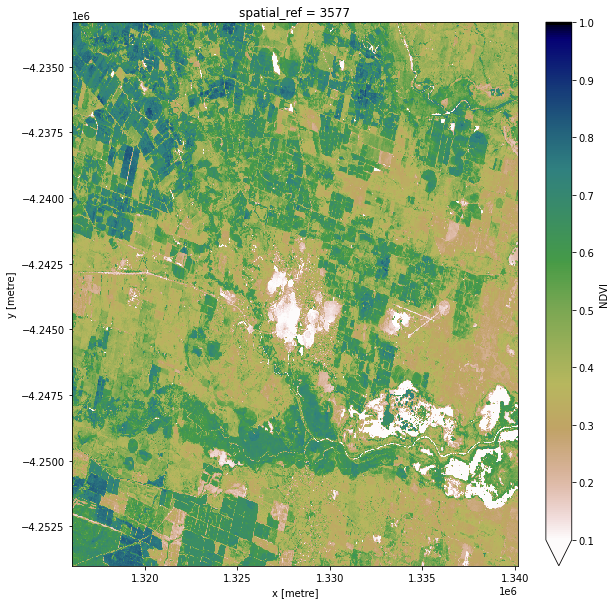

In [5]:
# First we calculate NDVI on each image in the timeseries
ndvi = calculate_indices(ds, index='NDVI', collection='ga_s2_1')

# For each pixel, calculate the mean NDVI throughout the whole timeseries
ndvi = ndvi.mean(dim='time', keep_attrs=True)

# Plot the results to inspect
ndvi.NDVI.plot(vmin=0.1, vmax=1.0, cmap='gist_earth_r', figsize=(10, 10))


## Quickshift Segmentation

Using the function [quickshift](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift) from the python package `scikit-image`, we will conduct an image segmentation on the mean NDVI array.  We then calculate a zonal mean across each segment using the input dataset. Our last step is to export our results as a GeoTIFF.

Follow the quickshift hyperlink above to see the input parameters to the algorithm, and the following [link](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html) for an explanation of quickshift and other segmentation algorithms in `scikit-image`.

In [6]:
# Convert our mean NDVI xarray into a numpy array, we need
# to be explicit about the datatype to satisfy quickshift
input_array = ndvi.NDVI.values.astype(np.float64)


In [7]:
# Calculate the segments
segments = quickshift(input_array,
                      kernel_size=5,
                      convert2lab=False,
                      max_dist=10,
                      ratio=1.0)


In [8]:
# Calculate the zonal mean NDVI across the segments
segments_zonal_mean_qs = scipy.ndimage.mean(input=input_array,
                                            labels=segments,
                                            index=segments)


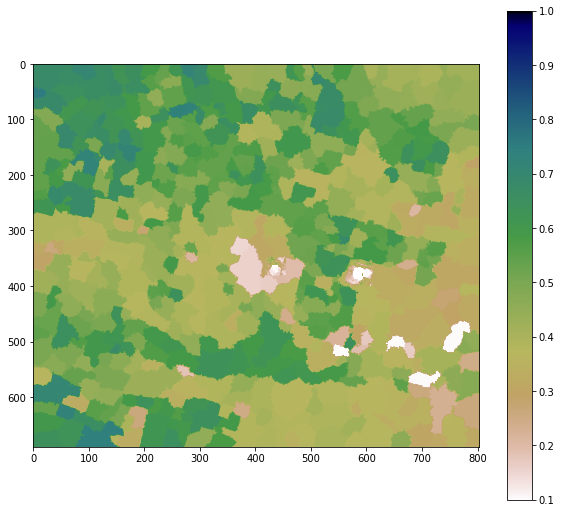

In [9]:
# Plot to see result
plt.figure(figsize=(10,10))
plt.imshow(segments_zonal_mean_qs, cmap='gist_earth_r', vmin=0.1, vmax=1.0)
plt.colorbar(shrink=0.9)


### Export result to GeoTIFF


In [10]:
path = "./outputs/Image_segmentation/"


transform = ds.geobox.transform.to_gdal()
projection = ds.geobox.crs.wkt

# Export the array
array_to_geotiff(path + 'segmented_meanNDVI_QS.tif',
                  segments_zonal_mean_qs,
                  geo_transform=transform,
                  projection=projection,
                  nodata_val=np.nan)


## Shepherd Segmentation
Here we conduct an image segmentation on the mean NDVI array using the [runShepherdSegmentation](https://www.rsgislib.org/rsgislib_segmentation.html) function from `rgislib`. 
This scalable segmentation algorithm is seeded using k-means clustering, and can enforce a minimum mapping unit size through an iterative clumping and elimination process [(Shepherd et al. 2019)](https://www.mdpi.com/2072-4292/11/6/658/htm).
This function will output a `.kea` file containing the segmented image, along with a segmented GeoTIFF where the segments are attributed with the zonal mean of the input GeoTIFF (in this case, NDVI). 

To better understand the parameters of the `runShepheredSegmentation` algorithm, read [here](https://www.rsgislib.org/rsgislib_segmentation.html).

The cell directly below sets up the inputs to the [runShepherdSegmentation](https://www.rsgislib.org/rsgislib_segmentation.html) function:


In [11]:
# Name of the GeoTIFF to export then and segment
tiff_to_segment = 'meanNDVI.tif' 

# Name of the .kea file the GeoTIFF will be converted too
kea_file = 'meanNDVI.kea'

# Name of the segmented .kea file that will be output 
segmented_kea_file = 'meanNDVI_segmented.kea'

# Name of the segmented .kea file attributed with the zonal mean of input file
segments_zonal_mean = 'segments_zonal_mean_shepherdSeg.kea'


We then write out our mean NDVI dataset to a GeoTIFF, and convert the GeoTIFF to a `.kea` file using `gdal.Translate` so it can be read by the `runShepherdSegmentation` function (the `.kea` file format provides a full implementation of the GDAL data model and is implemented within a HDF5 file):

In [12]:
# Write the mean NDVI dataset to be written to file as a GeoTIFF
write_cog(ndvi[['NDVI']].to_array(), fname=path + tiff_to_segment, overwrite=True)

# Convert the GeoTIFF into a KEA file format
gdal.Translate(destName=path + kea_file,
               srcDS=path + tiff_to_segment,
               format='KEA',
               outputSRS='EPSG:3577')


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f02f01c2120> >

We can then perform the segmentation on the `.kea` file:

In [13]:
# Run the image segmentation
segutils.runShepherdSegmentation(inputImg=path + kea_file,
                                 outputClumps=path + segmented_kea_file,
                                 outputMeanImg=path + segments_zonal_mean,
                                 numClusters=20,
                                 minPxls=200)


Stretch Input Image
Add 1 to stretched file to ensure there are no all zeros (i.e., no data) regions created.
Create Input Image Mask.
Mask stretched Image.
Deleting file: ./meanNDVI_stchdonly.kea
Deleting file: ./meanNDVI_stchdonlyOff.kea
Deleting file: ./meanNDVI_stchdmaskonly.kea
Performing KMeans.
Apply KMeans to image.
Eliminate Single Pixels.
Perform clump.
Eliminate small pixels.
Relabel clumps.
Calculate image statistics and build pyramids.
Deleting file: ./meanNDVI_kmeansclusters.gmtxt
Deleting file: ./meanNDVI_kmeans.kea.aux.xml
Deleting file: ./meanNDVI_kmeans.kea
Deleting file: ./meanNDVI_kmeans_nosgl.kea
Deleting file: ./meanNDVI_kmeans_nosglTMP.kea
Deleting file: ./meanNDVI_clumps.kea
Deleting file: ./meanNDVI_clumps_elim.kea
Deleting file: ./meanNDVI_stchd.kea


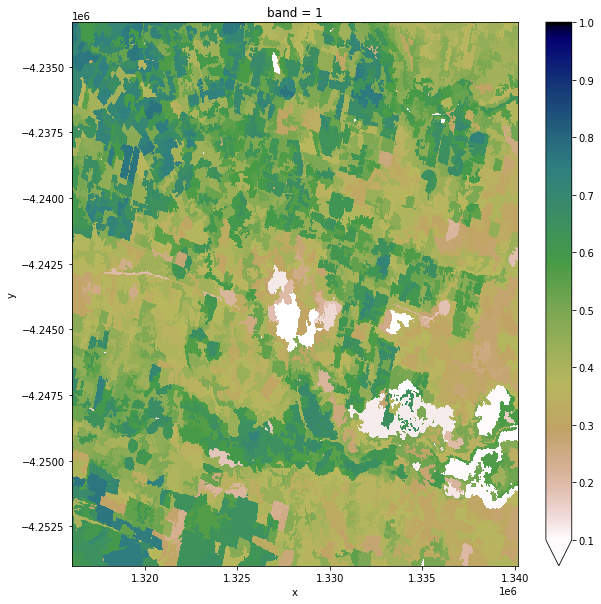

In [14]:
# Open and plot the segments attributed with zonal mean NDVI
result = xr.open_rasterio(path + segments_zonal_mean)
result.plot(vmin=0.1, vmax=1.0, figsize=(10, 10), cmap='gist_earth_r')


Note that we can also open the output `segmented_kea_file` `.kea` file using [xarray.open_rasterio](http://xarray.pydata.org/en/stable/generated/xarray.open_rasterio.html) to view the raw unattributed segments:

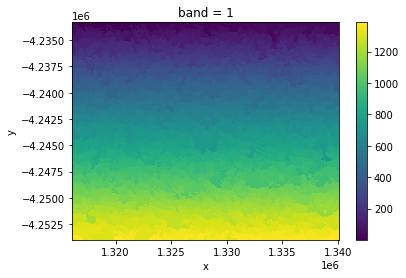

In [15]:
xr.open_rasterio(path + segmented_kea_file).plot()

***
## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please review the FAQ section and support options on the [EY Data Science platform](https://datascience.ey.com/).